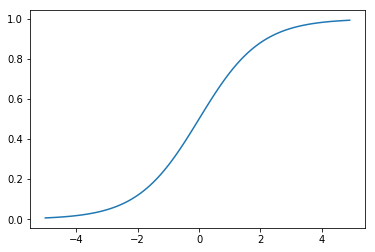

In [17]:
# Logistic Regression
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np

def logistic(z):
    return 1. / (1. + nd.exp(-z))

x = nd.arange(-5, 5, 0.1)
y = logistic(x)

plt.plot(x.asnumpy(),y.asnumpy())
plt.show()

In [18]:
# Data!
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Data
data_ctx = mx.cpu()
# Change this to `mx.gpu(0) if you would like to train on an NVIDIA GPU
model_ctx = mx.cpu()

with open("../data/a1a.train") as f:
    train_raw = f.read()

with open("../data/a1a.test") as f:
    test_raw = f.read()


In [19]:
# Data prep
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1) / 2  # Change label from {-1,1} to {0,1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y

Xtrain, Ytrain = process_data(train_raw)
Xtest, Ytest = process_data(test_raw)

In [36]:
# make sure data has correct shapes
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

# We can also check the fraction of positive examples in our training and test sets. 
# This will give us one nice (necessay but insufficient) sanity check that our training 
# and test data really are drawn from the same distribution.
print(nd.sum(Ytrain)/len(Ytrain))
print(nd.sum(Ytest)/len(Ytest))

(1605, 123)
(1605, 1)
(30956, 123)
(30956, 1)

[ 0.24610592]
<NDArray 1 @cpu(0)>

[ 0.24053495]
<NDArray 1 @cpu(0)>


In [37]:
# instantiate data loader
batch_size = 64

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, Ytrain),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, Ytest),
                                      batch_size=batch_size, shuffle=True)

# Define Model
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

# instantiate optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
# loss function (handmade)



In [38]:
# Define Loss
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Define-log-loss
# test_count = 0
def log_loss(output, y):
#     global test_count
    yhat = logistic(output)
#     if test_count < 4:
#         print(yhat)
#     test_count = test_count + 1
    return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

epochs = 100
loss_sequence = []
num_examples = len(Xtrain)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 3015.13751602
Epoch 1, loss: 2540.73989534
Epoch 2, loss: 2224.74924278
Epoch 3, loss: 2013.18921566
Epoch 4, loss: 1867.67290306
Epoch 5, loss: 1764.16248608
Epoch 6, loss: 1687.36694288
Epoch 7, loss: 1627.08540821
Epoch 8, loss: 1578.0642612
Epoch 9, loss: 1536.89241719
Epoch 10, loss: 1500.96107101
Epoch 11, loss: 1468.69545019
Epoch 12, loss: 1439.16143799
Epoch 13, loss: 1411.85789871
Epoch 14, loss: 1386.19249344
Epoch 15, loss: 1362.13398123
Epoch 16, loss: 1339.23761386
Epoch 17, loss: 1317.46235359
Epoch 18, loss: 1296.6304431
Epoch 19, loss: 1276.86709487
Epoch 20, loss: 1257.89353752
Epoch 21, loss: 1239.68704653
Epoch 22, loss: 1222.39107728
Epoch 23, loss: 1205.68341017
Epoch 24, loss: 1189.69730473
Epoch 25, loss: 1174.39500189
Epoch 26, loss: 1159.7017622
Epoch 27, loss: 1145.5148592
Epoch 28, loss: 1131.88916302
Epoch 29, loss: 1118.92273021
Epoch 30, loss: 1106.22411823
Epoch 31, loss: 1094.24569154
Epoch 32, loss: 1082.66067815
Epoch 33, loss: 1071.444

Text(0,0.5,'average loss')

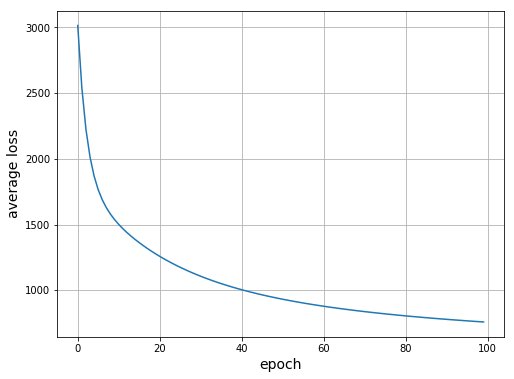

In [39]:
# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [40]:
# calculate accuracy
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Calculating-accuracy
num_correct = 0.0
num_total = len(Xtest)
for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    output = net(data)
#     print(nd.sign(output))
    prediction = (nd.sign(output) + 1) / 2
    num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

Accuracy: 0.787 (24377.0/30956)
